In [48]:
import os
import sys
import csv
import time
import chess
import chess.engine
import requests
import json
import pandas as pd
from dotenv import load_dotenv
from subprocess import Popen, PIPE, DEVNULL
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Constants
stockfish_exe = "/Users/saumik/Documents/classes/rotations/code/Stockfish/src/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_exe)
depth = 20
load_dotenv()   
token = os.getenv('LICHESS_TOKEN')

In [3]:
def get_fens(player, max_games='null', token=None):
    headers = {'Accept':'application/x-ndjson'}
    if token:
        headers['Authorization'] = f'Bearer {token}'
    params = {'max':max_games}
    response = requests.get(f"https://lichess.org/api/games/user/{player}", headers=headers, params=params)
    with open(f'data/{player}.csv', 'w') as f:
        for line in response.iter_lines():
            line = json.loads(line.decode('utf-8'))
            if line['variant'] == 'standard' and 'moves' in line:
                try:
                    color = 'w' if line['players']['white']['user']['name'] == player else 'b'
                except:
                    continue
                moves = line['moves'].split()
                board = chess.Board()
                for san in moves:
                    uci = board.parse_san(san).uci()
                    fen = board.fen()
                    movenum = int(fen.split()[5])
                    if fen.split()[1] == color and movenum >= 10 and movenum < 30:
                        print(f'{uci},{fen}', file=f)
                    board.push_uci(uci)

In [4]:
# for p in tqdm(top_blitz):
#     get_fens(p, max_games=100, token=token)

In [5]:
def clean_score(score):
    score = round(float(score),2)
    score = 2.0 if score > 2 else score
    score = -2.0 if score < -2 else score
    return score

def evaluate(fen, next_move=None):
    process = Popen(stockfish_exe, shell=True, stdin=PIPE, stdout=PIPE, stderr=DEVNULL)
    if next_move:
        output = process.communicate(input=str.encode(f"position fen {fen} moves {next_move}\neval\n"))[0]
    else:
        output = process.communicate(input=str.encode(f"position fen {fen}\neval\n"))[0]
    if process.returncode != 0:
        sys.stderr.write(f"Failed: {stockfish_exe}\n")
        sys.exit(1)

    # parse for parameter output
    components = ['Material','Imbalance','Mobility','King safety','Threats','Passed','Space','Winnable']
    scores = []
    for line in output.decode("utf-8").split("\n"):
        if any(c in line for c in components):
            mg_score = line.split('|')[3].split()[0]
            mg_score = clean_score(mg_score)
            scores.append(mg_score)
    return tuple(scores)

In [6]:
# Unused at the moment
def get_next_states(fen):
    board = chess.Board(fen)
    moves = [move.uci() for move in board.legal_moves]
    states = set()
    for move in tqdm(moves):
        scores = evaluate(fen, move)
        if scores != ():
            states.add(scores)
    return states

In [22]:
top_blitz = ['Konevlad', 'may6enexttime','IWANNABEADOORED','Ogrilla','cjota95',
             'alireza2003','Drvitman','black_knight22','NIndja64','Benefactorr']

In [8]:
def get_best_move(fen):
#     print(fen)
    board = chess.Board(fen=fen)
    info = engine.analyse(board, chess.engine.Limit(depth=20))
    return info['pv'][0]

In [9]:
def rm_paren(tup):
    if tup == ():
        return ',,,,,,,'
    return ','.join(str(i) for i in tup)

In [10]:
def get_avg_bias(player):
    total = [0,0,0,0,0,0,0,0]
    with open(f'data/{player}.csv', 'r') as f:
        with open(f'diffs/{player}.csv','w') as fw:
            csv_reader = csv.reader(f, delimiter=',')
#             count = 0
            for uci,fen in tqdm(csv_reader):
#                 if count >= 10:
#                     break
                current_eval = evaluate(fen)
                played_eval = evaluate(fen, uci)
                best = get_best_move(fen)
                best_eval = played_eval if str(best) == str(uci) else evaluate(fen, best)
                print(f'{fen},{rm_paren(current_eval)},{uci},{rm_paren(played_eval)},{best},{rm_paren(best_eval)}', file=fw)
#                 count+=1

In [11]:
for p in top_blitz:
    print(f'Starting {p}')
    get_avg_bias(p)
    time.sleep(1)
    

0it [00:00, ?it/s]

Starting Drvitman


1109it [34:34,  1.87s/it]
0it [00:00, ?it/s]

Starting black_knight22


1605it [48:55,  1.83s/it]
0it [00:00, ?it/s]

Starting NIndja64


1408it [41:51,  1.78s/it]
0it [00:00, ?it/s]

Starting Benefactorr


1680it [50:23,  1.80s/it]


In [12]:
def get_df(filename, cols, names):
    df = pd.read_csv(filename, names=names, index_col=False, usecols=['fen']+cols)
    df['color'] = df['fen'].apply(lambda x: x.split()[1])
    df = df.drop('fen', axis=1)
    df.loc[df['color'] == 'b',cols] = df*-1
    df = df.drop('color', axis=1)
    return df

In [17]:
def calc_bias(diffs_file):
    elen = 8
    fen_cols = [f'f{i}' for i in range(elen)]
    player_cols = [f'p{i}' for i in range(elen)]
    best_cols = [f'b{i}' for i in range(elen)]
    names = ['fen'] + fen_cols + ['player'] + player_cols + ['best'] + best_cols
    # skiprows = lambda x: x.split()[1] == 'b'

    df_fen = get_df(diffs_file, fen_cols, names)
    df_player = get_df(diffs_file, player_cols, names)
    df_best = get_df(diffs_file, best_cols, names)
    
    df_player_change = df_player - df_fen.values
    df_best_change = df_best - df_fen.values
    df_player_bias = df_player - df_best.values
    
    return df_player_change.mean(), df_best_change.mean(), df_player_bias.mean()

In [42]:
ans = [calc_bias(f'diffs/{i}.csv') for i in top_blitz]

pchange = pd.concat([i[0] for i in ans], axis=1).T
bchange = pd.concat([i[1] for i in ans], axis=1).T
pbias = pd.concat([i[2] for i in ans], axis=1).T

In [43]:
pchange

,p0,p1,p2,p3,p4,p5,p6,p7
0,0.447852,0.092609,0.067268,0.161833,0.151961,0.031395,0.025365,-0.000969
1,0.378053,0.086448,0.061594,0.149774,0.153172,0.031087,0.023116,0.000000
2,0.412359,0.090588,0.068874,0.145730,0.148394,0.030894,0.026092,-0.001012
3,0.419691,0.097995,0.061184,0.113813,0.128150,0.036252,0.024658,-0.000291
4,0.376687,0.087174,0.065991,0.134723,0.112248,0.023608,0.027537,-0.000018
5,0.372646,0.084055,0.065107,0.159624,0.161490,0.026615,0.023056,-0.000104
6,0.362972,0.088819,0.063297,0.162569,0.146112,0.039685,0.026506,-0.000039
7,0.397692,0.098222,0.061437,0.151771,0.154986,0.034372,0.023731,0.000105
8,0.351105,0.083445,0.062005,0.143049,0.138125,0.033849,0.030823,0.000000
9,0.409216,0.095221,0.071384,0.212446,0.178715,0.034621,0.031015,-0.000040


In [44]:
bchange

,b0,b1,b2,b3,b4,b5,b6,b7
0,0.435044,0.091800,0.066411,0.150584,0.143700,0.024752,0.025207,-0.000970
1,0.396141,0.088506,0.064316,0.176329,0.153760,0.024123,0.023743,0.000000
2,0.409187,0.090955,0.069642,0.139073,0.154969,0.024912,0.027351,-0.001381
3,0.434546,0.103001,0.062231,0.125610,0.138611,0.034348,0.027962,-0.000138
4,0.357890,0.089023,0.067741,0.132377,0.122589,0.024530,0.029235,-0.000019
5,0.379633,0.087382,0.061073,0.163582,0.145390,0.025557,0.022905,-0.000103
6,0.376650,0.091565,0.065723,0.190628,0.134237,0.036381,0.029870,-0.000040
7,0.446388,0.111152,0.061961,0.158946,0.138067,0.032396,0.025805,-0.000105
8,0.379284,0.089162,0.062970,0.142384,0.146657,0.034334,0.031546,0.000000
9,0.426930,0.096976,0.068709,0.219078,0.144433,0.033485,0.032563,-0.000145


In [45]:
pbias

,p0,p1,p2,p3,p4,p5,p6,p7
0,0.008796,0.002173,0.000803,0.007672,0.005396,0.006325,0.000201,0.000000
1,-0.026190,-0.002765,-0.002451,-0.030016,-0.001223,0.007419,-0.000904,0.000016
2,0.001219,-0.001146,-0.000306,0.006611,-0.006043,0.005092,-0.001180,0.000356
3,-0.017404,-0.004656,-0.000324,-0.010059,-0.009665,0.001995,-0.003114,-0.000153
4,0.023194,-0.001242,-0.001036,0.001236,-0.007206,-0.000158,-0.001667,0.000000
5,-0.007601,-0.002478,0.003657,-0.003337,0.014472,0.001051,0.000242,0.000000
6,-0.014136,-0.002593,-0.002446,-0.034145,0.012338,0.003910,-0.002475,0.000000
7,-0.046035,-0.011065,-0.000670,-0.003784,0.020837,0.001795,-0.001695,0.000174
8,-0.028221,-0.005330,-0.001164,-0.005241,-0.005841,-0.000778,-0.000615,0.000030
9,-0.022848,-0.002939,0.001696,-0.005638,0.033981,0.000764,-0.001663,0.000104


[0.60702869 0.22719804]


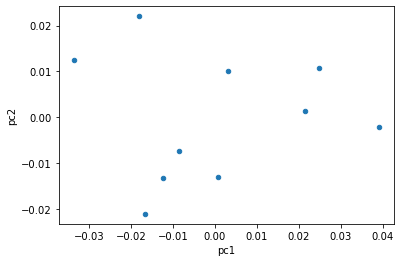

In [79]:
x_orig = pbias
pca_orig = PCA(n_components=2).fit(x_orig)
df_orig = pd.DataFrame(data=pca_orig.transform(x_orig),
                       columns = ['pc1','pc2'])
print(pca_orig.explained_variance_ratio_)
df_orig.plot.scatter(x='pc1',y='pc2')

[0.31771352 0.24951141]


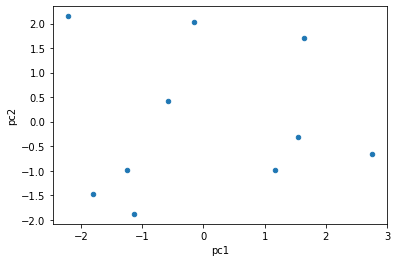

In [80]:
x_scal = StandardScaler().fit_transform(pbias)
pca_scal = PCA(n_components=2).fit(x_scal)
df_scal = pd.DataFrame(data=pca_scal.transform(x_scal),
                       columns = ['pc1','pc2'])
print(pca_scal.explained_variance_ratio_)
df_scal.plot.scatter(x='pc1',y='pc2')